In [2]:
# Set Up Drive, Kaggle  and Download Dataset
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# verify kaggle works
!kaggle datasets list

# Download the dataset (12K images)
!kaggle datasets download -d abdelrahmanemad2199/corn-or-maize-leaf-disease-dataset

# Unzip the dataset (replace 'dataset-identifier.zip' with the actual downloaded zip file name
!unzip corn-or-maize-leaf-disease-dataset.zip -d /content/dataset

from google.colab import drive
drive.mount('/content/drive')

# Move the dataset to your Google Drive
# !mv /content/dataset /content/drive/MyDrive/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8da48548-461c-4574-9435-74310d8207a3___RS_GLSp 4387_90deg.JPG  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8da48548-461c-4574-9435-74310d8207a3___RS_GLSp 4387_new30degFlipLR.JPG  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8ead1e08-eb49-4c03-b99f-f46f3597087d___RS_GLSp 4474 copy.jpg  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8ead1e08-eb49-4c03-b99f-f46f3597087d___RS_GLSp 4474 copy_270deg.jpg  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8ead1e08-eb49-4c03-b99f-f46f3597087d___RS_GLSp 4474 copy_90deg.jpg  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/8ead1e08-eb49-4c03-b99f-f46f3597087d___RS_GLSp 4474 copy_new30degFlipLR.jpg  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/9043a294-8d22-405f-add1-7e5bf1606e7a___RS_GLSp 4431 copy 2.jpg  
  inflating: /content/dataset/corn/data/Gray_Leaf_Spot/9043a294-8d22-405f-add1-7e5

In [22]:
import tensorflow as tf
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Dataset directory and parameters
dataset_dir = '/content/drive/MyDrive/dataset/corn/data'
target_size = (256, 256)
batch_size = 32

# Get class names and encode labels
class_names = os.listdir(dataset_dir)
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

# Load file paths and labels
file_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file_name))
        labels.append(class_name)

file_paths = np.array(file_paths)
labels = np.array(labels)

# Encode labels
def encode_labels(labels):
    return label_encoder.transform(labels)

# Split data into training + validation (90%) and test (10%)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.1, stratify=labels, random_state=42
)

# Split training + validation into training (70%) and validation (20%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=42
)

# Update dataset creation function
def load_and_preprocess_image(file_path, target_size):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    return image

def create_dataset(file_paths, labels, batch_size, is_training):
    labels = encode_labels(labels)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x, target_size), y))
    if is_training:
        dataset = dataset.map(lambda x, y: (augment_image(x), y))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = create_dataset(train_paths, train_labels, batch_size, is_training=True)
validation_dataset = create_dataset(val_paths, val_labels, batch_size, is_training=False)
test_dataset = create_dataset(test_paths, test_labels, batch_size, is_training=False)



# Check dataset formats
for images, labels in train_dataset.take(1):
    print('Train images shape:', images.shape)
    print('Train labels shape:', labels.shape)
    print('Sample labels:', labels.numpy())

for images, labels in validation_dataset.take(1):
    print('Validation images shape:', images.shape)
    print('Validation labels shape:', labels.shape)
    print('Sample labels:', labels.numpy())


Train images shape: (32, 256, 256, 3)
Train labels shape: (32,)
Sample labels: [1 0 3 0 1 0 0 1 0 0 3 0 1 3 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0]
Validation images shape: (32, 256, 256, 3)
Validation labels shape: (32,)
Sample labels: [0 3 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 3]


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get class distribution
def get_class_distribution(labels):
    class_counts = pd.Series(labels).value_counts()
    return class_counts

# Get class distributions for train, validation, and test sets
train_class_counts = get_class_distribution(train_labels)
val_class_counts = get_class_distribution(val_labels)
test_class_counts = get_class_distribution(test_labels)

print("Train class distribution:\n", train_class_counts)
print("Validation class distribution:\n", val_class_counts)
print("Test class distribution:\n", test_class_counts)


Train class distribution:
 Common_Rust       2574
Healthy           2503
Blight            1975
Gray_Leaf_Spot    1847
Name: count, dtype: int64
Validation class distribution:
 Common_Rust       644
Healthy           625
Blight            494
Gray_Leaf_Spot    462
Name: count, dtype: int64
Test class distribution:
 Common_Rust       358
Healthy           348
Blight            274
Gray_Leaf_Spot    256
Name: count, dtype: int64


<ipython-input-10-779b63a368a4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


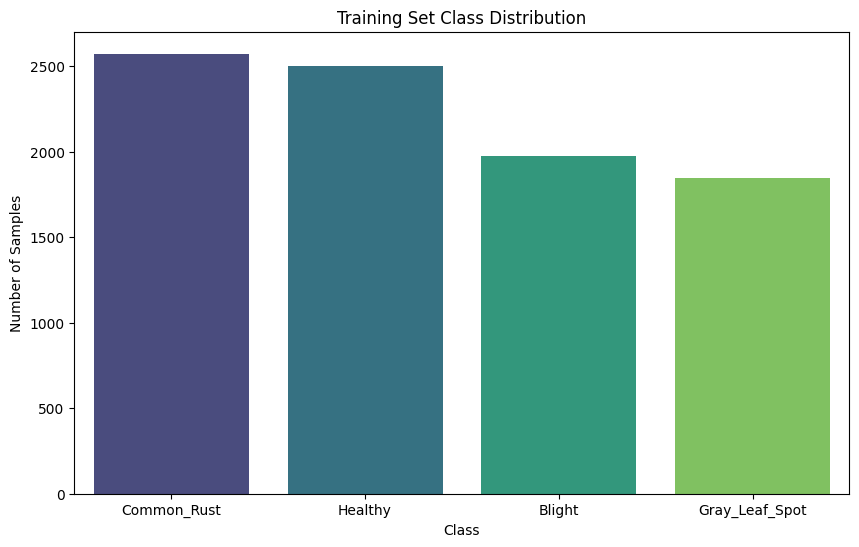

<ipython-input-10-779b63a368a4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


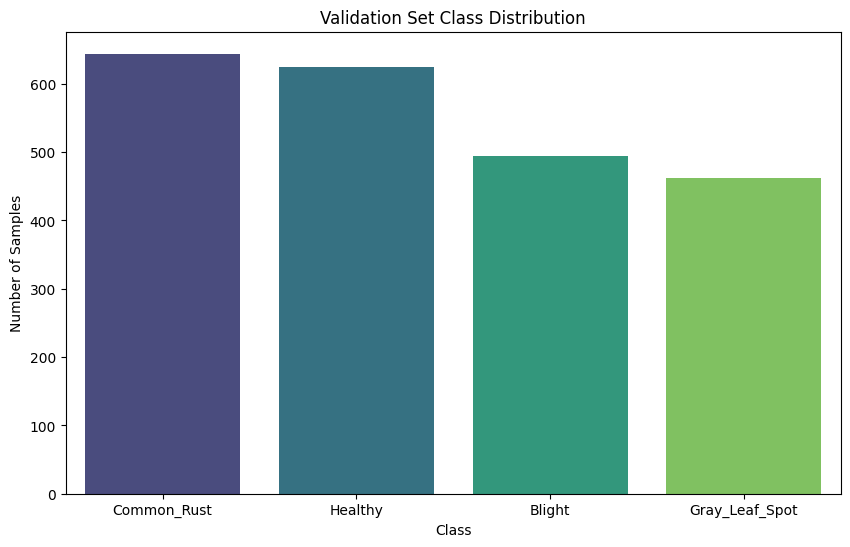

<ipython-input-10-779b63a368a4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


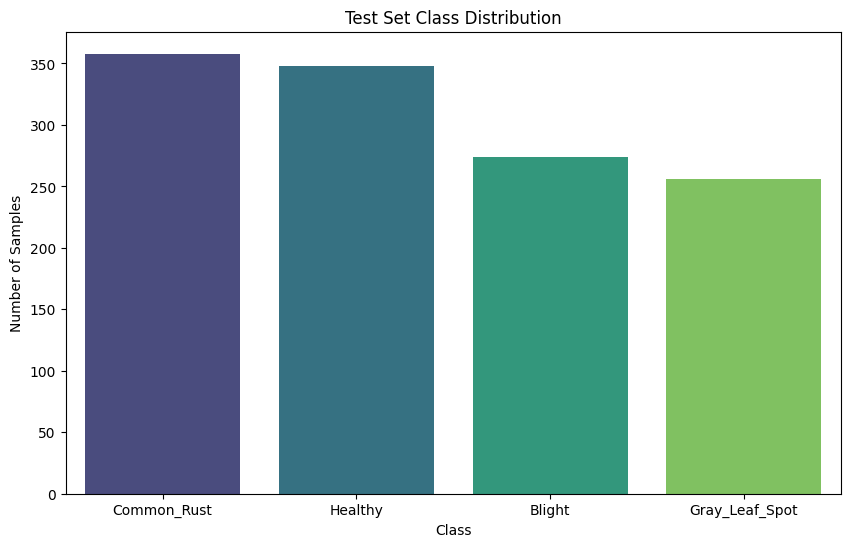

In [10]:
# Function to plot class distribution
def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

# Plot distributions
plot_class_distribution(train_class_counts, "Training Set Class Distribution")
plot_class_distribution(val_class_counts, "Validation Set Class Distribution")
plot_class_distribution(test_class_counts, "Test Set Class Distribution")


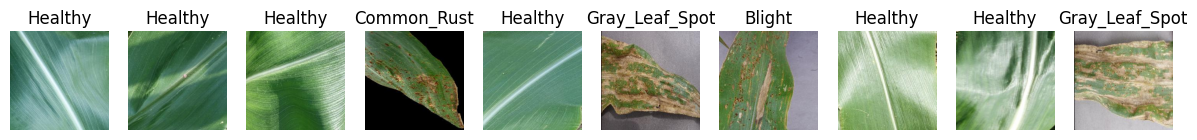

In [11]:
import random
from PIL import Image

def show_random_samples(file_paths, labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = random.randint(0, len(file_paths) - 1)
        img_path = file_paths[idx]
        img_label = labels[idx]
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(img_label)
        plt.axis('off')
    plt.show()

# Show random samples from the dataset
show_random_samples(file_paths, labels, num_samples=10)


In [23]:
def print_summary_statistics(class_counts):
    print(f"Number of samples per class:\n{class_counts}")

print_summary_statistics(train_class_counts)
print_summary_statistics(val_class_counts)
print_summary_statistics(test_class_counts)


Number of samples per class:
Common_Rust       2574
Healthy           2503
Blight            1975
Gray_Leaf_Spot    1847
Name: count, dtype: int64
Number of samples per class:
Common_Rust       644
Healthy           625
Blight            494
Gray_Leaf_Spot    462
Name: count, dtype: int64
Number of samples per class:
Common_Rust       358
Healthy           348
Blight            274
Gray_Leaf_Spot    256
Name: count, dtype: int64


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load and prepare the base model with MobileNetV2
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Define the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Assuming 4 classes for maize leaf diseases
])

# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
optimizer = Nadam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

<ipython-input-24-f8e18460ead5>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


In [25]:
# Training

import os

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/a1.keras', save_best_only=True, )

# Check if the checkpoint file exists
if os.path.exists('/content/drive/MyDrive/a1.keras'):
    # Load the best weights saved by the checkpoint
    model.load_weights('/content/drive/MyDrive/a1.keras')
    print("Best model weights loaded successfully!")
else:
    print("No previous checkpoint found. Training from scratch...")


# Train the model

for images, labels in train_dataset.take(1):
    print('Train images shape:', images.shape)
    print('Train labels shape:', labels.shape)
    print('Sample labels:', labels.numpy())

for images, labels in validation_dataset.take(1):
    print('Validation images shape:', images.shape)
    print('Validation labels shape:', labels.shape)
    print('Sample labels:', labels.numpy())

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)


No previous checkpoint found. Training from scratch...
Train images shape: (32, 256, 256, 3)
Train labels shape: (32,)
Sample labels: [1 0 3 0 1 0 0 1 0 0 3 0 1 3 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0]
Validation images shape: (32, 256, 256, 3)
Validation labels shape: (32,)
Sample labels: [0 3 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 3]
Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 750s 8s/step - accuracy: 0.8391 - loss: 0.4554 - val_accuracy: 0.9852 - val_loss: 0.0457
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.9686 - loss: 0.1083 - val_accuracy: 0.9812 - val_loss: 0.0482
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.9668 - loss: 0.1001 - val_accuracy: 0.9879 - val_loss: 0.0427
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.9810 - loss: 0.0682 - val_accuracy: 0.9879 - val_loss: 0.0371
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.9700 - loss: 0.0916 - val_accuracy: 0.9826 - val_loss: 0.0415
Ep

In [26]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 89s 7s/step - accuracy: 0.9968 - loss: 0.0083
Test Loss: 0.006869423668831587
Test Accuracy: 0.9975845217704773


In [28]:
# save the model

model.save('/content/drive/MyDrive/final_model_new.keras')


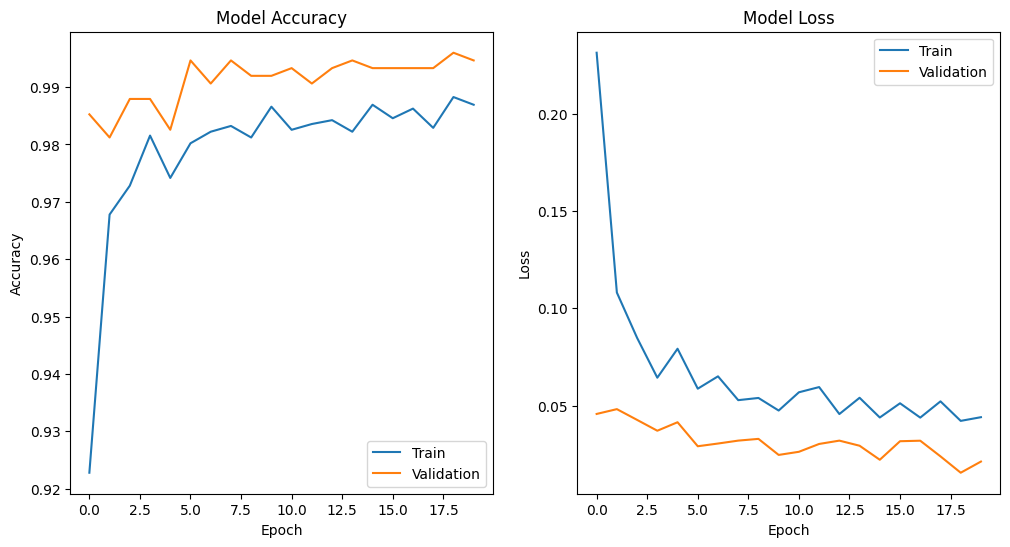

In [29]:
import matplotlib.pyplot as plt

# Assuming `history` is the result of model.fit()
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.show()

# Plot the metrics
plot_metrics(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


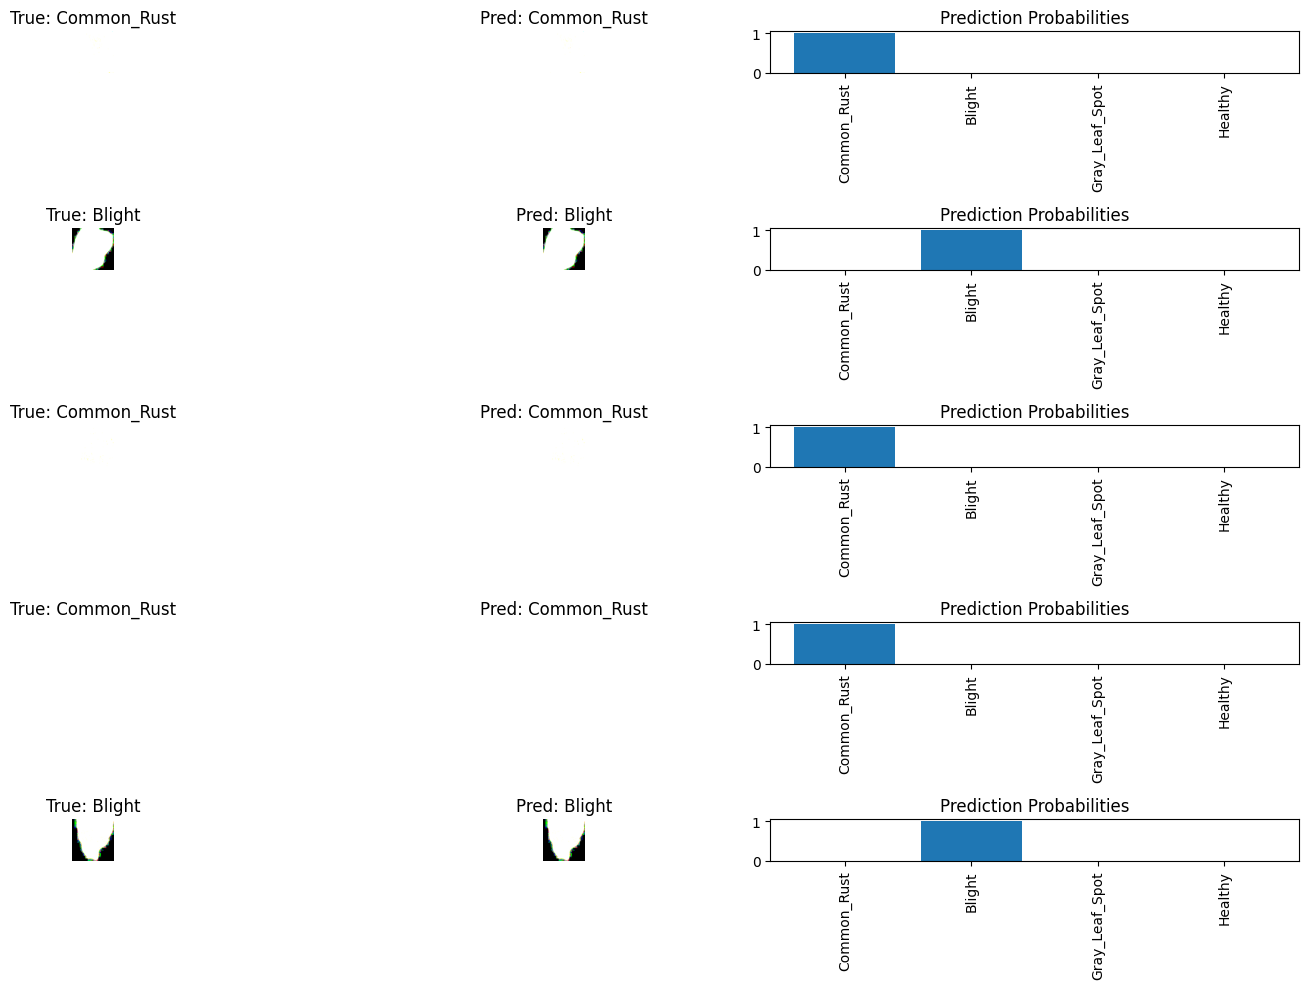

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot random predictions
def plot_random_predictions(dataset, model, class_names, num_samples=5):
    # Get a batch of images and labels
    images, labels = next(iter(dataset))

    # Make predictions
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Convert labels to original class names
    labels = np.array([class_names[label] for label in labels])
    predicted_labels = np.array([class_names[label] for label in predicted_labels])

    # Plot random samples
    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[idx])
        plt.title(f"True: {labels[idx]}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(images[idx])
        plt.title(f"Pred: {predicted_labels[idx]}")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.bar(range(len(class_names)), predictions[idx])
        plt.title("Prediction Probabilities")
        plt.xticks(range(len(class_names)), class_names, rotation=90)

    plt.tight_layout()
    plt.show()

# Plot random predictions
plot_random_predictions(test_dataset, model, class_names)
